### 1. 协同过滤算法

协同过滤（Collaborative Filtering）推荐算法是最经典、最常用的推荐算法。

所谓协同过滤， 基本思想是**根据用户之前的喜好以及其他兴趣相近的用户的选择来给用户推荐物品**(基于对用户历史行为数据的挖掘发现用户的喜好偏向， 并预测用户可能喜好的产品进行推荐)，**一般是仅仅基于用户的行为数据（评价、购买、下载等）, 而不依赖于项的任何附加信息（物品自身特征）或者用户的任何附加信息（年龄， 性别等）**。目前应用比较广泛的协同过滤算法是基于邻域的方法， 而这种方法主要有下面两种算法：


* **基于用户的协同过滤算法(UserCF)**: 给用户推荐和他兴趣相似的其他用户喜欢的产品
* **基于物品的协同过滤算法(ItemCF)**: 给用户推荐和他之前喜欢的物品相似的物品

不管是UserCF还是ItemCF算法， 非常重要的步骤之一就是计算用户和用户或者物品和物品之间的相似度， 所以下面先整理常用的相似性度量方法， 然后再对每个算法的具体细节进行展开。

<br/>

### 2. 相似性度量方法

1. **杰卡德(Jaccard)相似系数**
   这个是衡量两个集合的相似度一种指标。两个用户$u$和$v$交互商品交集的数量占这两个用户交互商品并集的数量的比例，称为两个集合的杰卡德相似系数，用符号$sim_{uv}$表示，其中$N(u),N(v)$分别表示用户$u$和用户$v$交互商品的集合。
   $$
   sim_{uv}=\frac{|N(u) \cap N(v)|}{\sqrt{|N(u)| \cup|N(v)|}}
   $$
   由于杰卡德相似系数一般无法反映具体用户的评分喜好信息， 所以常用来评估用户是否会对某商品进行打分， 而不是预估用户会对某商品打多少分。

   <br>

2. **余弦相似度**
   余弦相似度衡量了两个向量的夹角，夹角越小越相似。首先从集合的角度描述余弦相似度，相比于Jaccard公式来说就是分母有差异，不是两个用户交互商品的并集的数量，而是两个用户分别交互的商品数量的乘积，公式如下：
   $$
   sim_{uv}=\frac{|N(u)| \cap |N(v)|}{\sqrt{|N(u)|\cdot|N(v)|}}
   $$
   从向量的角度进行描述，令矩阵$A$为用户-商品交互矩阵(因为是TopN推荐并不需要用户对物品的评分，只需要知道用户对商品是否有交互就行)，即矩阵的每一行表示一个用户对所有商品的交互情况，有交互的商品值为1没有交互的商品值为0，矩阵的列表示所有商品。若用户和商品数量分别为$m,n$的话，交互矩阵$A$就是一个$m$行$n$列的矩阵。此时用户的相似度可以表示为(其中$u\cdot v$指的是向量点积)：
   $$
   sim_{uv} = cos(u,v) =\frac{u\cdot v}{|u|\cdot |v|}
   $$
   上述用户-商品交互矩阵在现实情况下是非常的稀疏了，为了避免存储这么大的稀疏矩阵，在计算用户相似度的时候一般会采用集合的方式进行计算。理论上向量之间的相似度计算公式都可以用来计算用户之间的相似度，但是会根据实际的情况选择不同的用户相似度度量方法。

   这个在具体实现的时候， 可以使用`cosine_similarity`进行实现：




In [7]:
from sklearn.metrics.pairwise import cosine_similarity
i = [1, 0, 0, 0]
j = [1, 0.5, 0.5, 0]
cosine_similarity([i, j])

array([[1.        , 0.81649658],
       [0.81649658, 1.        ]])

In [11]:
import numpy as np
np.linalg.norm(j)   # L2 范数

1.224744871391589

3. **皮尔逊相关系数**

   皮尔逊相关系数的公式与余弦相似度的计算公式非常的类似，首先对于上述的余弦相似度的计算公式写成求和的形式,其中$r_{ui},r_{vi}$分别表示用户$u$和用户$v$对商品$i$是否有交互(或者具体的评分值)：
   $$
   sim_{uv} = \frac{\sum_i r_{ui}*r_{vi}}{\sqrt{\sum_i r_{ui}^2}\sqrt{\sum_i r_{vi}^2}}
   $$
   如下是皮尔逊相关系数计算公式，其中$r_{ui},r_{vi}$分别表示用户$u$和用户$v$对商品$i$是否有交互(或者具体的评分值)，$\bar r_u, \bar r_v$分别表示用户$u$和用户$v$交互的所有商品交互数量或者具体评分的平均值。
   $$
   sim(u,v)=\frac{\sum_{i\in I}(r_{ui}-\bar r_u)(r_{vi}-\bar r_v)}{\sqrt{\sum_{i\in I }(r_{ui}-\bar r_u)^2}\sqrt{\sum_{i\in I }(r_{vi}-\bar r_v)^2}}
   $$
   所以相比余弦相似度，皮尔逊相关系数通过使用用户的平均分对各独立评分进行修正，减小了用户评分偏置的影响。具体实现， 我们也是可以调包， 这个计算方式很多， 下面是其中的一种：

In [8]:
from scipy.stats import pearsonr

i = [1, 0, 0, 0]
j = [1, 0.5, 0.5, 0]
pearsonr(i, j)

(0.816496580927726, 0.18350341907227397)

### 3. 基于用户的协同过滤

基于用户的协同过滤（以下用UserCF表示），思想其实比较简单，**当一个用户A需要个性化推荐的时候， 我们可以先找到和他有相似兴趣的其他用户， 然后把那些用户喜欢的， 而用户A没有听说过的物品推荐给A**。

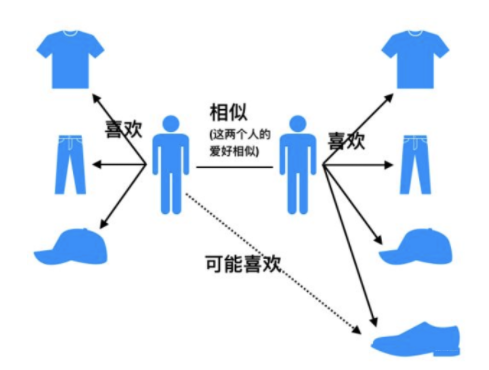

**UserCF算法主要包括两个步骤：**


1. 找到和目标用户兴趣相似的集合
2. 找到这个集合中的用户喜欢的， 且目标用户没有听说过的物品推荐给目标用户。

上面的两个步骤中， 第一个步骤里面， 我们会基于前面给出的相似性度量的方法找出与目标用户兴趣相似的用户， 而第二个步骤里面， 如何基于相似用户喜欢的物品来对目标用户进行推荐呢？ 这个要依赖于目标用户对相似用户喜欢的物品的一个喜好程度， 那么如何衡量这个程度大小呢？  为了更好理解上面的两个步骤， 下面拿一个具体的例子把两个步骤具体化。

**以下图为例，此例将会用于本文各种算法中**

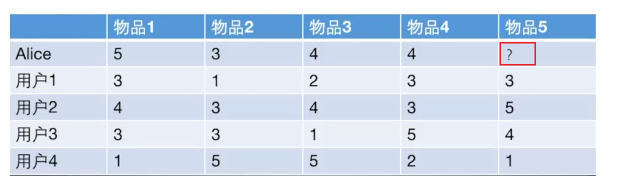

给用户推荐物品的过程可以**形象化为一个猜测用户对商品进行打分的任务**，上面表格里面是5个用户对于5件物品的一个打分情况，就可以理解为用户对物品的喜欢程度

应用UserCF算法的两个步骤：


1. 首先根据前面的这些打分情况(或者说已有的用户向量）计算一下Alice和用户1， 2， 3， 4的相似程度， 找出与Alice最相似的n个用户
2. 根据这n个用户对物品5的评分情况和与Alice的相似程度会猜测出Alice对物品5的评分， 如果评分比较高的话， 就把物品5推荐给用户Alice， 否则不推荐。

关于第一个步骤， 上面已经给出了计算两个用户相似性的方法， 这里不再过多赘述， 这里主要解决第二个问题， 如何产生最终结果的预测。 

<br>

**最终结果的预测**

根据上面的几种方法， 我们可以计算出向量之间的相似程度， 也就是可以计算出Alice和其他用户的相近程度， 这时候我们就可以选出与Alice最相近的前n个用户， 基于他们对物品5的评价猜测出Alice的打分值， 那么是怎么计算的呢？

这里常用的方式之一是**利用用户相似度和相似用户的评价加权平均获得用户的评价预测**， 用下面式子表示：

$$
R_{\mathrm{u}, \mathrm{p}}=\frac{\sum_{\mathrm{s} \in S}\left(w_{\mathrm{u}, \mathrm{s}} \cdot R_{\mathrm{s}, \mathrm{p}}\right)}{\sum_{\mathrm{s} \in S} w_{\mathrm{u}, \mathrm{s}}}
$$
这个式子里面， 权重$w_{u,s}$是用户$u$和用户$s$的相似度， $R_{s,p}$是用户$s$对物品$p$的评分。

还有一种方式如下， 这种方式考虑的更加前面， 依然是用户相似度作为权值， 但后面不单纯的是其他用户对物品的评分， 而是**该物品的评分与此用户的所有评分的差值进行加权平均， 这时候考虑到了有的用户内心的评分标准不一的情况**， 即有的用户喜欢打高分， 有的用户喜欢打低分的情况。

$$
P_{i, j}=\bar{R}_{i}+\frac{\sum_{k=1}^{n}\left(S_{i, k}\left(R_{k, j}-\bar{R}_{k}\right)\right)}{\sum_{k=1}^{n} S_{j, k}}
$$
所以这一种计算方式更为推荐。下面的计算将使用这个方式。

在获得用户$u$对不同物品的评价预测后， 最终的推荐列表根据预测评分进行排序得到。 至此，基于用户的协同过滤算法的推荐过程完成。

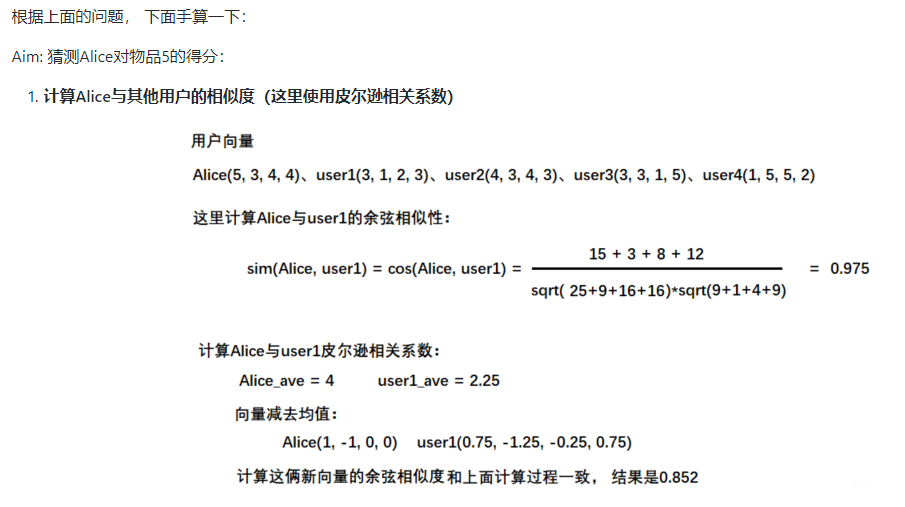

这里我们使用皮尔逊相关系数， 也就是Alice与用户1的相似度是0.85。同样的方式， 我们就可以计算与其他用户的相似度， 这里可以使用numpy的相似度函数得到用户的相似性矩阵：

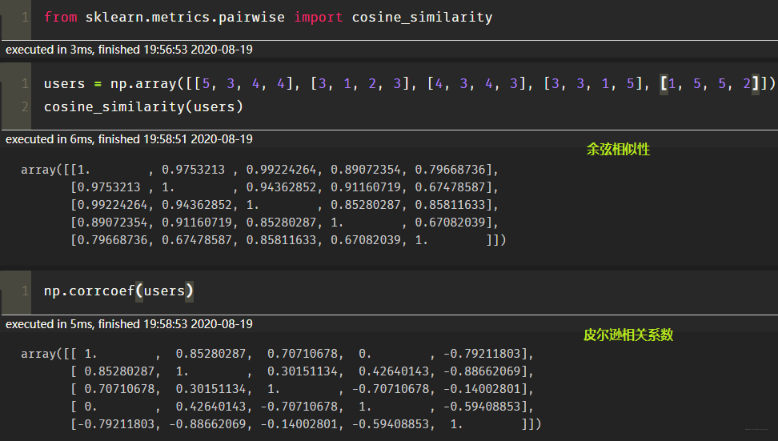

1.  从这里看出, Alice用户和用户2,用户3,用户4的相似度是0.7，0, -0.79。 所以如果n=2， 找到与Alice最相近的两个用户是用户1， 和Alice的相似度是0.85， 用户2， 和Alice相似度是0.7

2. **根据相似度用户计算Alice对物品5的最终得分**
   用户1对物品5的评分是3， 用户2对物品5的打分是5， 那么根据上面的计算公式， 可以计算出Alice对物品5的最终得分是

$$
P_{Alice, 物品5}=\bar{R}_{Alice}+\frac{\sum_{k=1}^{2}\left(S_{Alice,user k}\left(R_{userk, 物品5}-\bar{R}_{userk}\right)\right)}{\sum_{k=1}^{2} S_{Alice, userk}}=4+\frac{0.85*(3-2.4)+0.7*(5-3.8)}{0.85+0.7}=4.87
$$

3. **根据用户评分对用户进行推荐**
   这时候， 我们就得到了Alice对物品5的得分是4.87， 根据Alice的打分对物品排个序从大到小：$$物品1>物品5>物品3=物品4>物品2$$
   这时候，如果要向Alice推荐2款产品的话， 我们就可以推荐物品1和物品5给Alice

  至此， 基于用户的协同过滤算法原理介绍完毕。

##  UserCF编程实现

这里简单的通过编程实现上面的案例，为后面的大作业做一个热身， 梳理一下上面的过程其实就是三步： 计算用户相似性矩阵、得到前n个相似用户、计算最终得分。

In [3]:
import numpy as np
import pandas as pd

In [4]:
# 定义数据集， 也就是那个表格， 注意这里我们采用字典存放数据， 因为实际情况中数据是非常稀疏的， 很少有情况是现在这样
def loadData():
    items={'A': {1: 5, 2: 3, 3: 4, 4: 3, 5: 1},
           'B': {1: 3, 2: 1, 3: 3, 4: 3, 5: 5},
           'C': {1: 4, 2: 2, 3: 4, 4: 1, 5: 5},
           'D': {1: 4, 2: 3, 3: 3, 4: 5, 5: 2},
           'E': {2: 3, 3: 5, 4: 4, 5: 1}
          }
    users={1: {'A': 5, 'B': 3, 'C': 4, 'D': 4},
           2: {'A': 3, 'B': 1, 'C': 2, 'D': 3, 'E': 3},
           3: {'A': 4, 'B': 3, 'C': 4, 'D': 3, 'E': 5},
           4: {'A': 3, 'B': 3, 'C': 1, 'D': 5, 'E': 4},
           5: {'A': 1, 'B': 5, 'C': 5, 'D': 2, 'E': 1}
          }
    return items,users

items, users = loadData()
item_df = pd.DataFrame(items).T
user_df = pd.DataFrame(users).T

In [6]:
user_df

,A,B,C,D,E
1,5.0,3.0,4.0,4.0,NaN
2,3.0,1.0,2.0,3.0,3.0
3,4.0,3.0,4.0,3.0,5.0
4,3.0,3.0,1.0,5.0,4.0
5,1.0,5.0,5.0,2.0,1.0


In [64]:
user_test = user_df.T
user_test

,1,2,3,4,5
A,5.0,3.0,4.0,3.0,1.0
B,3.0,1.0,3.0,3.0,5.0
C,4.0,2.0,4.0,1.0,5.0
D,4.0,3.0,3.0,5.0,2.0
E,NaN,3.0,5.0,4.0,1.0


###  DataFrame.corr()  和 np.corrcoef()  比较

np.corrcoef()  对 Nan值容忍度很低，处理或者计算不了 Nan值

In [65]:
user_df
a = user_df.loc[1]
b = user_df.loc[2]
# a,b
np.corrcoef(a,b,rowvar=True)

array([[nan, nan],
       [nan,  1.]])

DataFrame.corr() 方法对DataFrame每两列数据，使用 np.corrcoef()方法，可以处理Nan值

In [69]:
# 计算用户相似性矩阵
similarity_matrix = user_test.corr()
similarity_matrix

,1,2,3,4,5
1,1.000000,0.852803,0.707107,0.000000,-0.792118
2,0.852803,1.000000,0.467707,0.489956,-0.900149
3,0.707107,0.467707,1.000000,-0.161165,-0.466569
4,0.000000,0.489956,-0.161165,1.000000,-0.641503
5,-0.792118,-0.900149,-0.466569,-0.641503,1.000000


In [75]:
"""计算前n个相似的用户"""
# 注意，排除自身的相关系数，为 1
n = 3
similarity_users = similarity_matrix[1].sort_values(ascending=False)[1:n].index.tolist()    # [2, 3]   也就是用户1和用户2
similarity_users

[2, 3]

In [92]:
user_df

,A,B,C,D,E
1,5.0,3.0,4.0,4.0,NaN
2,3.0,1.0,2.0,3.0,3.0
3,4.0,3.0,4.0,3.0,5.0
4,3.0,3.0,1.0,5.0,4.0
5,1.0,5.0,5.0,2.0,1.0


这种方式考虑的更加前面， 依然是用户相似度作为权值， 但后面不单纯的是其他用户对物品的评分， 而是**该物品的评分与此用户的所有评分的差值进行加权平均， 这时候考虑到了有的用户内心的评分标准不一的情况**， 即有的用户喜欢打高分， 有的用户喜欢打低分的情况。

$$
P_{i, j}=\bar{R}_{i}+\frac{\sum_{k=1}^{n}\left(S_{i, k}\left(R_{k, j}-\bar{R}_{k}\right)\right)}{\sum_{k=1}^{n} S_{j, k}}
$$
所以这一种计算方式更为推荐。下面的计算将使用这个方式。

举例：
1. **根据相似度用户计算Alice对物品5的最终得分**
   用户1对物品5的评分是3， 用户2对物品5的打分是5， 那么根据上面的计算公式， 可以计算出Alice对物品5的最终得分是

$$
P_{Alice, 物品5}=\bar{R}_{Alice}+\frac{\sum_{k=1}^{2}\left(S_{Alice,user k}\left(R_{userk, 物品5}-\bar{R}_{userk}\right)\right)}{\sum_{k=1}^{2} S_{Alice, userk}}=4+\frac{0.85*(3-2.4)+0.7*(5-3.8)}{0.85+0.7}=4.87
$$


In [107]:
# 计算最终结果值
# base_score  = user_df.mean(axis=1).loc[similarity_users].values.tolist() 
corr_value  = similarity_matrix[1].sort_values(ascending=False)[1:n].tolist() 

weighted_scores = 0
for user in similarity_users:
    corr_values_sum  = sum(corr_value)
    weighted_scores  += similarity_matrix[1][user] * (user_df['E'][user] - user_df.mean(axis=1)[user] )
final_scores  = user_df.mean(axis=1)[1] + weighted_scores / corr_values_sum
final_scores

4.871979899370592

In [109]:
user_df.loc[1]['E'] = final_scores
user_df

,A,B,C,D,E
1,5.0,3.0,4.0,4.0,4.87198
2,3.0,1.0,2.0,3.0,3.00000
3,4.0,3.0,4.0,3.0,5.00000
4,3.0,3.0,1.0,5.0,4.00000
5,1.0,5.0,5.0,2.0,1.00000


###  结论：给用户 1 推荐 A 物品 和 E 物品

## itemCF 

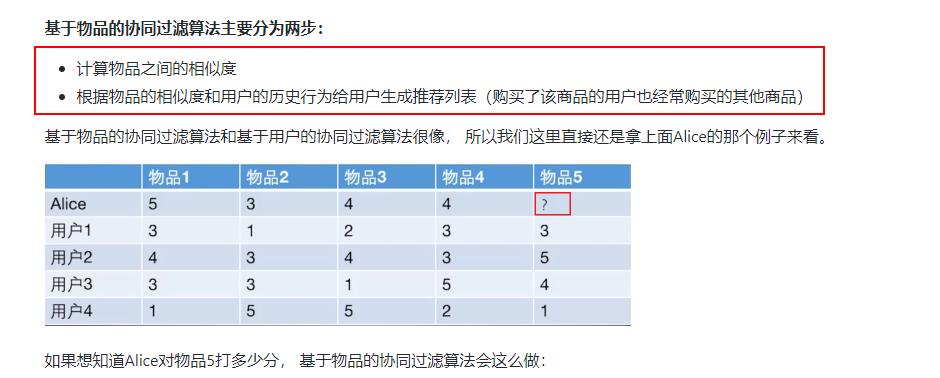


In [111]:
item_df = item_df.T
item_df

,A,B,C,D,E
1,5.0,3.0,4.0,4.0,NaN
2,3.0,1.0,2.0,3.0,3.0
3,4.0,3.0,4.0,3.0,5.0
4,3.0,3.0,1.0,5.0,4.0
5,1.0,5.0,5.0,2.0,1.0


In [113]:
similarity_matrix_items = item_df.corr()
similarity_matrix_items

,A,B,C,D,E
A,1.000000,-0.476731,-0.123091,0.532181,0.969458
B,-0.476731,1.000000,0.645497,-0.310087,-0.478091
C,-0.123091,0.645497,1.000000,-0.720577,-0.427618
D,0.532181,-0.310087,-0.720577,1.000000,0.581675
E,0.969458,-0.478091,-0.427618,0.581675,1.000000


根据皮尔逊相关系数， 可以找到与物品5最相似的2个物品是item1和item4(n=2)， 下面基于上面的公式计算最终得分：

$$
P_{Alice, 物品5}=\bar{R}_{物品5}+\frac{\sum_{k=1}^{2}\left(S_{物品5,物品 k}\left(R_{Alice, 物品k}-\bar{R}_{物品k}\right)\right)}{\sum_{k=1}^{2} S_{物品k, 物品5}}=\frac{13}{4}+\frac{0.97*(5-3.2)+0.58*(4-3.4)}{0.97+0.58}=4.6
$$


这时候依然可以向Alice推荐物品5。下面也是简单编程实现一下，  和上面的差不多：

In [116]:
"""计算前n个相似的物品"""
# 注意，排除自身的相关系数，为 1
n = 3
similarity_users = similarity_matrix_items['E'].sort_values(ascending=False)[1:n].index.tolist()    # [2, 3]   也就是用户1和用户2
similarity_users

['A', 'D']

In [1]:
# 计算最终结果值
# base_score  = user_df.mean(axis=1).loc[similarity_users].values.tolist() 
corr_value  = similarity_matrix_items['E'].sort_values(ascending=False)[1:n].tolist() 

weighted_scores = 0
for item in similarity_items:
    corr_values_sum  = sum(corr_value)
    weighted_scores  += similarity_matrix_items['E'][item] * (item_df.loc[1][item] - item_df.mean(axis=0)[item] )
final_scores  = item_df.mean(axis=0)['E'] + weighted_scores / corr_values_sum
final_scores

NameError: name 'similarity_matrix_items' is not defined

In [127]:
item_df

,A,B,C,D,E
1,5.0,3.0,4.0,4.0,NaN
2,3.0,1.0,2.0,3.0,3.0
3,4.0,3.0,4.0,3.0,5.0
4,3.0,3.0,1.0,5.0,4.0
5,1.0,5.0,5.0,2.0,1.0


In [131]:
item_df['E'][1] = final_scores
item_df

,A,B,C,D,E
1,5.0,3.0,4.0,4.0,4.625
2,3.0,1.0,2.0,3.0,3.000
3,4.0,3.0,4.0,3.0,5.000
4,3.0,3.0,1.0,5.0,4.000
5,1.0,5.0,5.0,2.0,1.000


###  结论：给用户 1 推荐 A 物品 和 E 物品

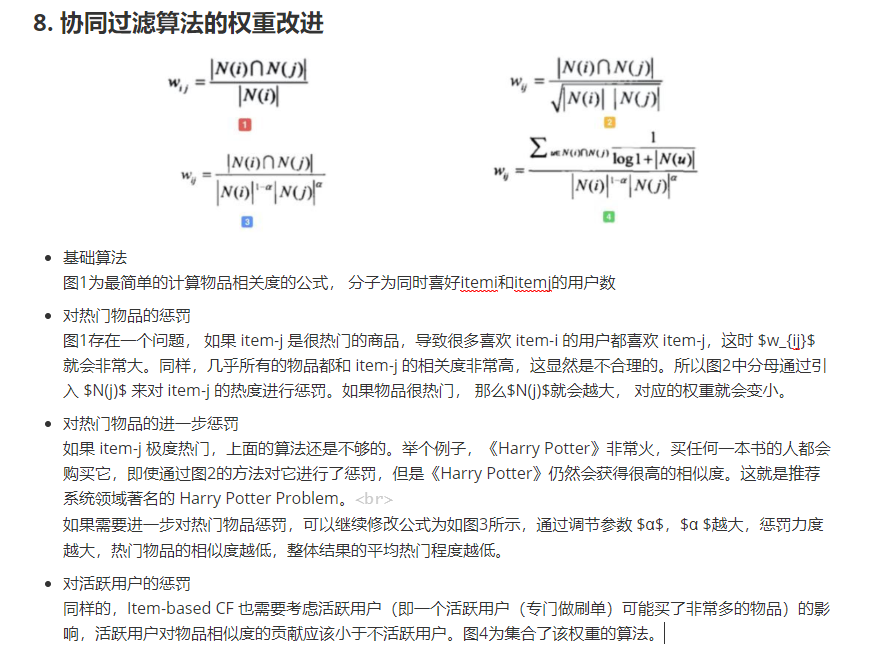

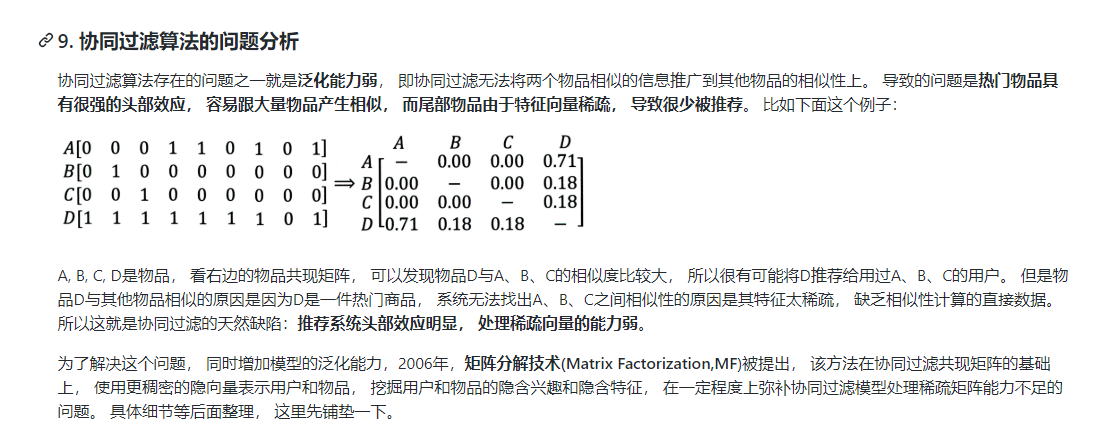

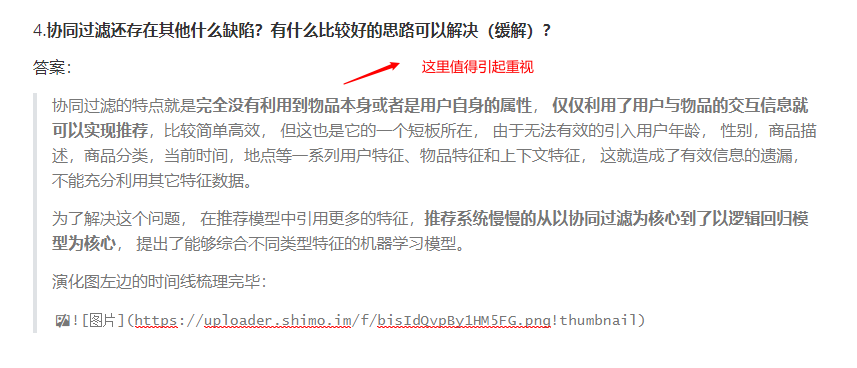